In [ ]:
from threeML import *

import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
triggerName = 'bn090217206'
ra = 204.9
dec = -8.4

#Data are in the current directory

datadir = os.path.abspath('.')

#Create an instance of the GBM plugin for each detector
#Data files
obsSpectrum = os.path.join( datadir, "bn090217206_n6_srcspectra.pha{1}" )
bakSpectrum = os.path.join( datadir, "bn090217206_n6_bkgspectra.bak{1}" )
rspFile     = os.path.join( datadir, "bn090217206_n6_weightedrsp.rsp{1}" )

#Plugin instance
NaI6 = OGIPLike( "NaI6", obsSpectrum, bakSpectrum, rspFile )

#Choose energies to use (in this case, I exclude the energy
#range from 30 to 40 keV to avoid the k-edge, as well as anything above
#950 keV, where the calibration is uncertain)
NaI6.set_active_measurements( "10.0-30.0", "40.0-950.0" )


In [ ]:
#This declares which data we want to use. In our case, all that we have already created.

data_list = DataList( NaI6 )

In [4]:
powerlaw = Powerlaw()

In [5]:
GRB = PointSource( triggerName, ra, dec, spectral_shape=powerlaw )

In [6]:
model = Model( GRB )

In [7]:
jl = JointLikelihood( model, data_list, verbose=False )

res = jl.fit()

Best fit values:



#,Name,Best fit value,Unit
0,bn090217206.spectrum.main.Powerlaw.K,2.53 +/- 0.21,1 / (cm2 keV s)
1,bn090217206.spectrum.main.Powerlaw.index,-1.183 +/- 0.015,



NOTE: errors on parameters are approximate. Use get_errors().


Correlation matrix:



1.00,-0.98
-0.98,1.00



Values of -log(likelihood) at the minimum:



,-log(likelihood)
total,869.098857
NaI6,869.098857


In [8]:
#bn090217206.spectrum.main.Powerlaw.K	2.57 -0.19 +0.22	1 / (cm2 keV s)
#bn090217206.spectrum.main.Powerlaw.index	-1.185 -0.015 +0.014	


res = jl.get_errors()

Name,Value,Unit
bn090217206.spectrum.main.Powerlaw.K,2.53 -0.20 +0.21,1 / (cm2 keV s)
bn090217206.spectrum.main.Powerlaw.index,-1.183 -0.015 +0.015,


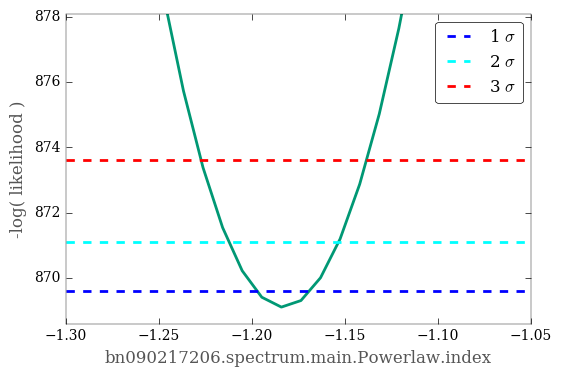

In [9]:
res = jl.get_contours(powerlaw.index,-1.3,-1.1,20)

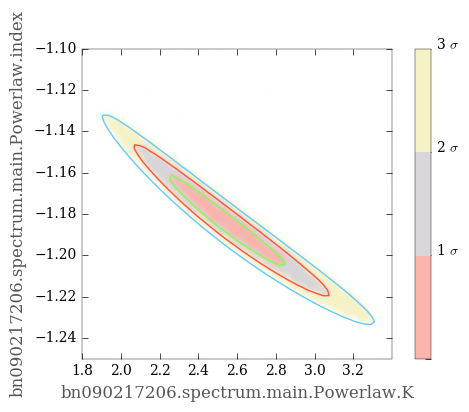

In [10]:
res = jl.get_contours(powerlaw.index,-1.25,-1.1,60,powerlaw.K,1.8,3.4,60)

In [11]:
powerlaw.index.prior = Uniform_prior(lower_bound=-5.0, upper_bound=5.0)
powerlaw.K.prior = Log_uniform_prior(lower_bound=1.0, upper_bound=10)

bayes = BayesianAnalysis(model, data_list)

In [12]:
samples = bayes.sample(n_walkers=50,burn_in=100, n_samples=1000)

Running burn-in of 100 samples...


Sampling...


Mean acceptance fraction: 0.71434


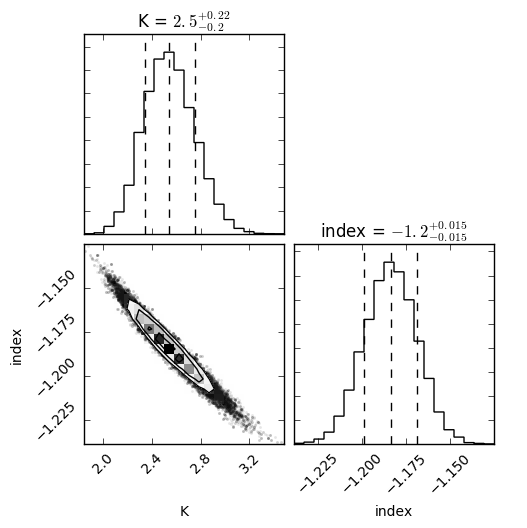

In [13]:
fig = bayes.corner_plot()